## Instructions

You are asked to complete the following files:
* **pruned_layers.py**, which contains the pruning of DNNs to reduce the storage of insignificant weight parameters with 2 methods: pruning by percentage and prune by standara deviation.
* **train_util.py**, which includes the training process of DNNs with pruned connections.
* **quantize.py**, which applies the quantization (weight sharing) part on the DNN to reduce the storage of weight parameters.
* **huffman_coding.py**, which applies the Huffman coding onto the weight of DNNs to further compress the weight size.

You are asked to submit the following files:
* **net_before_pruning.pt**, which is the weight parameters before applying pruning on DNN weight parameters.
* **net_after_pruning.pt**, which is the weight parameters after applying pruning on DNN weight parameters.
* **net_after_quantization.pt**, which is the weight parameters after applying quantization (weight sharing) on DNN weight parameters.
* **codebook_vgg16.npy**, which is the quantization codebook of each layer after applying quantization (weight sharing).
* **huffman_encoding.npy**, which is the encoding map of each item within the quantization codebook in the whole DNN architecture.
* **huffman_freq.npy**, which is the frequency map of each item within the quantization codebook in the whole DNN. 

To ensure fair grading policy, we fix the choice of model to VGG16_half, which is a down-scaled version of VGG16 using a width multiplier of 0.5. You may check the implementation in **vgg16.py** for more details.

In [1]:
from vgg16 import VGG16, VGG16_half
from train_util import train, finetune_after_prune, test, finetune_after_quantization
from quantize import quantize_whole_model
from huffman_coding import huffman_coding
from summary import summary
import torch
import numpy as np
from prune import prune
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import sklearn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Full-precision model training

In [2]:
net = VGG16_half()
net = net.to(device)

# Uncomment to load pretrained weights
#net.load_state_dict(torch.load("net_before_pruning.pt"))


# Comment if you have loaded pretrained weights
# Tune the hyperparameters here.
INITIAL_LR = 0.055
REG = 8e-4
EPOCHS = 75 #20
BATCH_SIZE = 256
train(net, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=INITIAL_LR, reg=REG)


In [3]:
# Load the best weight parameters
net.load_state_dict(torch.load("net_before_pruning.pt"))
test(net)

Files already downloaded and verified
Test Loss=0.3108, Test accuracy=0.9152


In [4]:
print("-----Summary before pruning-----")
summary(net)
print("-------------------------------")

-----Summary before pruning-----
Layer id	Type		Parameter	Non-zero parameter	Sparsity(\%)
1		Convolutional	864		864			0.000000
2		BatchNorm	N/A		N/A			N/A
3		ReLU		N/A		N/A			N/A
4		Convolutional	9216		9216			0.000000
5		BatchNorm	N/A		N/A			N/A
6		ReLU		N/A		N/A			N/A
7		Convolutional	18432		18432			0.000000
8		BatchNorm	N/A		N/A			N/A
9		ReLU		N/A		N/A			N/A
10		Convolutional	36864		36864			0.000000
11		BatchNorm	N/A		N/A			N/A
12		ReLU		N/A		N/A			N/A
13		Convolutional	73728		73728			0.000000
14		BatchNorm	N/A		N/A			N/A
15		ReLU		N/A		N/A			N/A
16		Convolutional	147456		147456			0.000000
17		BatchNorm	N/A		N/A			N/A
18		ReLU		N/A		N/A			N/A
19		Convolutional	147456		147456			0.000000
20		BatchNorm	N/A		N/A			N/A
21		ReLU		N/A		N/A			N/A
22		Convolutional	294912		294912			0.000000
23		BatchNorm	N/A		N/A			N/A
24		ReLU		N/A		N/A			N/A
25		Convolutional	589824		589824			0.000000
26		BatchNorm	N/A		N/A			N/A
27		ReLU		N/A		N/A			N/A
28		Convolutional	589824		589824			0.000000
29		Batch

### Pruning & Finetune with pruned connections

In [ ]:
# Test accuracy before fine-tuning
prune(net, method='std', q=66.8753, s = 1.25) # 1.25
test(net)

In [ ]:
# Uncomment to load pretrained weights
net.load_state_dict(torch.load("net_after_pruning.pt"))
# Comment if you have loaded pretrained weights
finetune_after_prune(net, epochs=10, batch_size=256, lr=0.001, reg=5e-5)

In [5]:
# Load the best weight parameters
net.load_state_dict(torch.load("net_after_pruning.pt"))
test(net)

Files already downloaded and verified
Test Loss=0.3480, Test accuracy=0.8995


In [6]:
print("-----Summary After pruning-----")
summary(net)
print("-------------------------------")

-----Summary After pruning-----
Layer id	Type		Parameter	Non-zero parameter	Sparsity(\%)
1		Convolutional	864		113			0.869213
2		BatchNorm	N/A		N/A			N/A
3		ReLU		N/A		N/A			N/A
4		Convolutional	9216		1107			0.879883
5		BatchNorm	N/A		N/A			N/A
6		ReLU		N/A		N/A			N/A
7		Convolutional	18432		2856			0.845052
8		BatchNorm	N/A		N/A			N/A
9		ReLU		N/A		N/A			N/A
10		Convolutional	36864		6190			0.832086
11		BatchNorm	N/A		N/A			N/A
12		ReLU		N/A		N/A			N/A
13		Convolutional	73728		12272			0.833550
14		BatchNorm	N/A		N/A			N/A
15		ReLU		N/A		N/A			N/A
16		Convolutional	147456		24806			0.831774
17		BatchNorm	N/A		N/A			N/A
18		ReLU		N/A		N/A			N/A
19		Convolutional	147456		24098			0.836575
20		BatchNorm	N/A		N/A			N/A
21		ReLU		N/A		N/A			N/A
22		Convolutional	294912		44970			0.847514
23		BatchNorm	N/A		N/A			N/A
24		ReLU		N/A		N/A			N/A
25		Convolutional	589824		84209			0.857230
26		BatchNorm	N/A		N/A			N/A
27		ReLU		N/A		N/A			N/A
28		Convolutional	589824		81276			0.862203
29		BatchNorm	N/A

### Quantization

In [ ]:
net.load_state_dict(torch.load("net_after_pruning.pt"))
centers = quantize_whole_model(net, bits=4)

np.save("codebook_vgg16.npy", centers)

print("Saving...")
torch.save(net.state_dict(), "net_after_quantization.pt")

test(net)

In [7]:
# Uncomment to load pretrained weights
net.load_state_dict(torch.load("net_after_quantization.pt"))
# Comment if you have loaded pretrained weights
finetune_after_quantization(net, epochs=5, batch_size=256, lr=0.001, reg=5e-5)
test(net)

Files already downloaded and verified
Test Loss=0.3525, Test accuracy=0.8972


In [8]:
summary(net)

Layer id	Type		Parameter	Non-zero parameter	Sparsity(\%)
1		Convolutional	864		113			0.869213
2		BatchNorm	N/A		N/A			N/A
3		ReLU		N/A		N/A			N/A
4		Convolutional	9216		1107			0.879883
5		BatchNorm	N/A		N/A			N/A
6		ReLU		N/A		N/A			N/A
7		Convolutional	18432		2856			0.845052
8		BatchNorm	N/A		N/A			N/A
9		ReLU		N/A		N/A			N/A
10		Convolutional	36864		6190			0.832086
11		BatchNorm	N/A		N/A			N/A
12		ReLU		N/A		N/A			N/A
13		Convolutional	73728		12272			0.833550
14		BatchNorm	N/A		N/A			N/A
15		ReLU		N/A		N/A			N/A
16		Convolutional	147456		24806			0.831774
17		BatchNorm	N/A		N/A			N/A
18		ReLU		N/A		N/A			N/A
19		Convolutional	147456		24098			0.836575
20		BatchNorm	N/A		N/A			N/A
21		ReLU		N/A		N/A			N/A
22		Convolutional	294912		44970			0.847514
23		BatchNorm	N/A		N/A			N/A
24		ReLU		N/A		N/A			N/A
25		Convolutional	589824		84209			0.857230
26		BatchNorm	N/A		N/A			N/A
27		ReLU		N/A		N/A			N/A
28		Convolutional	589824		81276			0.862203
29		BatchNorm	N/A		N/A			N/A
30		ReLU		N/A		N/A		

### Huffman Coding

In [9]:
net.load_state_dict(torch.load("net_after_quantization.pt"))
centers = np.load("codebook_vgg16.npy")
frequency_map, encoding_map = huffman_coding(net, centers)
np.save("huffman_encoding", encoding_map)
np.save("huffman_freq", frequency_map)

Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.7788 bits
Complete 1 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.6694 bits
Complete 2 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.6401 bits
Complete 3 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.6302 bits
Complete 4 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.6285 bits
Complete 5 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Average storage for each parameter after Huffman Coding: 4.6752 bits
Complete 6 layers for Huffman Coding...
Original storage for each parameter: 5.0000 bits
Ave

### Weight Visualization

Parameter containing:
tensor([0.3798, 0.3615, 0.1040, 0.2815, 0.4390, 0.1532, 0.5035, 0.1199, 0.0064,
        0.2706, 0.1908, 0.2142, 0.2110, 0.0194, 0.3515, 0.3837, 0.0053, 0.3496,
        0.1642, 0.2042, 0.2816, 0.1916, 0.2265, 0.5013, 0.0033, 0.3221, 0.0905,
        0.4349, 0.3615, 0.3752, 0.3417, 0.3994], device='cuda:0',
       requires_grad=True)


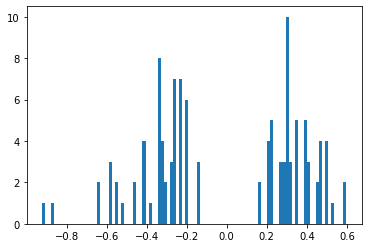

In [10]:
# #SCRATCH WORK:
# #prune(net, method='percentage', q = 50)
# #test(net)
# #plt.plot(x, norm.pdf(x))
# #plt.hist(net.classifer[0].linear.weight.data.cpu()[1], bins='auto')
# params = list(net.parameters())
# layer1weights = np.array(params[0].data.cpu().numpy()).flatten()
# #print(layer1weights)
# #print(np.array(params[0].data.cpu()))
# #print(np.std(layer1weights))
# print(np.percentile(abs(layer1weights), q=5.0))
# pruned_data = layer1weights.copy()
# pruned_data[abs(pruned_data)<=np.percentile(abs(layer1weights), q=20.0)] = None
# plt.hist(abs(layer1weights))
# plt.show()
# plt.hist(pruned_data, bins =40)

# Visualize Weight Distributions
params = list(net.parameters())
print(params[:][1])
layer1weights = np.array(params[0].data.cpu().numpy()).flatten()[np.nonzero(np.array(params[0].data.cpu().numpy()).flatten())]
plt.hist(layer1weights, bins = 100)
plt.show()

### Scratch Pad

#### Testing out how k-means works

In [ ]:
# A = np.array([1,2,3,4,5,6,7,8,9,10]).reshape(-1,1)
# kmean = sklearn.cluster.KMeans(n_clusters = 4,#2**bits, 
#                            init='k-means++', 
#                            n_init=10, 
#                            max_iter=300)
# labels = kmean.fit_predict(A)
# print(labels)
# print(kmean.cluster_centers_)
# print(labels==3)
# new = np.ones(A.shape)
# new[labels==3] = kmean.cluster_centers_[3]
# print(new)

#### Testing out how I can make the huffman encodings/frequency dict

In [ ]:
#from collections import Counter, OrderedDict
# A = np.array([0,1,0,2,0,3,0,1,0,4,0,5,0,1,0,2,0,3])
# non_zero_A = map(str, A[np.nonzero(A)])
# freq = dict(Counter(non_zero_A))
# print(freq)
# for key, value in freq.items():
#     print(key, '->', value)
# cp = freq.copy()
# print(cp)

#### Testing out list comprehension

In [ ]:
# test_list = []
# inter = [1,2,3]
# another = [inter,'1', '2', '3']
# test_list.extend(another)
# print(test_list[0])
# inter[0] = 0
# print(test_list[0])

#### Testing if Huffman Encoding is working

In [ ]:
# class HuffmanNode():
#     def __init__(self, key = '<!$>_ANTHONY_<$!>', freq = 0, right = None, left = None, leaf = False):
#         if leaf:
#             self.key = key
#             self.freq = freq
#             self.right = None
#             self.left = None
#             self.leaf = True
#             self.encode = ''
#         else:
#             self.key = key
#             self.freq = right.freq + left.freq
#             self.right = right
#             self.left = left
#             self.leaf = False
#             right.add_encode('1')
#             left.add_encode('0')
#         return
#     def add_encode(self, addition):
#         if self.leaf == False:
#             if self.left == None:
#                 self.right.add_encode(addition)
#             elif self.right == None:
#                 self.left.add_encode(addition)
#             else:
#                 self.right.add_encode(addition)
#                 self.left.add_encode(addition)
#             if self.right == None and self.left == None:
#                 print('Error: Recursively iterating on a leaf')
#         else:
#             self.encode = addition + self.encode
#         return

# def convert_freq_dict_to_encodings(freq):
#     original_freq = freq.copy() # Just in Case I want to check something later
    
#     leaf_list = []
#     for centroid, frequency in freq.items():
#         leaf_list.append(HuffmanNode(key = centroid,
#                                      freq = frequency,
#                                      leaf = True))
#     tree = []
#     tree.extend(leaf_list)
    
#     MaxIter = 500
#     iter = 0
#     not_root = True
    
#     # Forming Huffman Tree and Setting Encoding
#     while not_root and iter < MaxIter:
#         least_freq_item = tree.pop(-1)
#         second_least_freq_item = tree.pop(-1)
#         tree.append(HuffmanNode(key = 'Branch ' + str(iter),
#                                 right = second_least_freq_item,
#                                 left = least_freq_item))
#         iter+=1
#         not_root = len(tree) > 1
#         if not_root:
#             if tree[-1].freq > tree[-2].freq:
#                 tree = sorted(tree, key=lambda node: node.freq, reverse = True)
#     encodings = {}
#     for leaf in leaf_list:
#         encodings[leaf.key] = leaf.encode
#     return encodings


# def _huffman_coding_per_layer(weight, centers):
#     """
#     Huffman coding for each layer
#     :param weight: weight parameter of the current layer.
#     :param centers: KMeans centroids in the quantization codebook of the current weight layer.
#     :return: 
#             'encodings': Encoding map mapping each weight parameter to its Huffman coding.
#             'frequency': Frequency map mapping each weight parameter to the total number of its appearance.
#             'encodings' should be in this format:
#             {"0.24315": '0', "-0.2145": "100", "1.1234e-5": "101", ...
#             }
#             'frequency' should be in this format:
#             {"0.25235": 100, "-0.2145": 42, "1.1234e-5": 36, ...
#             }
#             'encodings' and 'frequency' does not need to be ordered in any way.
#     """
#     """
#     Generate Huffman Coding and Frequency Map according to incoming weights and centers (KMeans centroids).
#     --------------Your Code---------------------
#     """
#     non_zero_weights = list(map(str, weight[np.nonzero(weight)]))# creates string array of non-zero weight values
#     ordered = Counter(non_zero_weights)
#     # creates dictionary of centroids in decending order of frequency
#     frequency = {}
#     for item in ordered.most_common(len(ordered)):
#         key = item[0]
#         value = item[1]
#         frequency[key] = value
#     encodings = convert_freq_dict_to_encodings(frequency) # converts freq dict to centroid encodings
#     return encodings, frequency

In [ ]:
# weight_matrix = np.array([1,0,1,0,1,2,3,4,5,6,6,0,1,1,1]).reshape(-1,1)
# kmean = sklearn.cluster.KMeans(n_clusters = 7, 
#                                init='k-means++', 
#                                 n_init=20, 
#                                max_iter=300)
# labels = kmean.fit_predict(weight_matrix)
# print(labels)
# print(kmean.cluster_centers_)

In [ ]:
# encodings,frequency = _huffman_coding_per_layer(weight_matrix, kmean.cluster_centers_)

In [ ]:
# print(encodings)

In [ ]:
# print(frequency)